In [2]:
import os
from glob import glob
from pathlib import Path

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from utils.plotting import plot_trajectory
from utils.processing import (
    normalize,
    open_file,
    cut_jumps
    )

DATA_DIR = 'dataset'
PREPROC_DATA_DIR = 'preprocessed_dataset'

Here we preprocess data:

1. Load trajectories, remove mice jumps onto walls

2. Normalize x and y values in [-40, 40] range

3. Adress gaps in recordings and inconsistent dt

4. Resample data to given sampling rate

5. Add new infromation (i.e. angles, delta angels, etc.)

6. Save preprocessed data to new files 

# Preprocessing

In [3]:
dataset_names = sorted(glob(os.path.join(DATA_DIR, '*.txt')))
datasets = {}
for nam in dataset_names:
    k = Path(nam).stem
    v = open_file(nam, show=False)
    datasets[k] = v

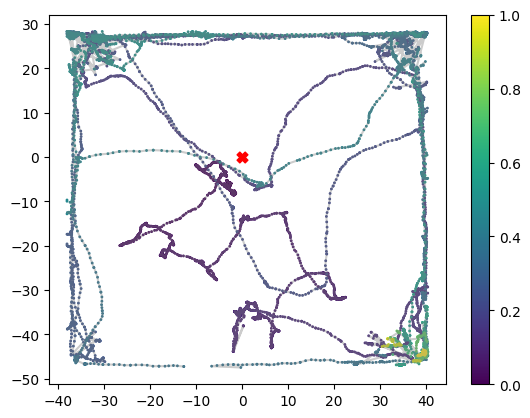

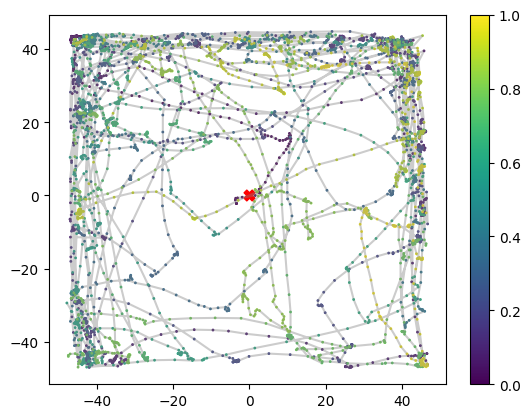

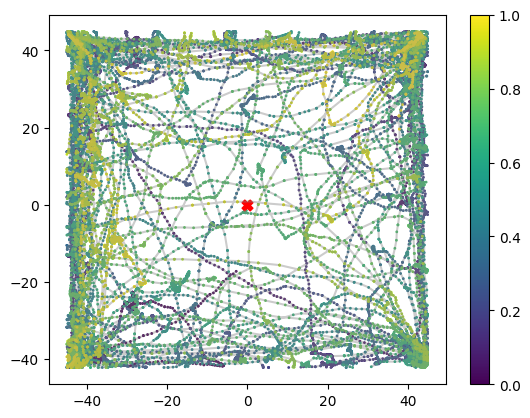

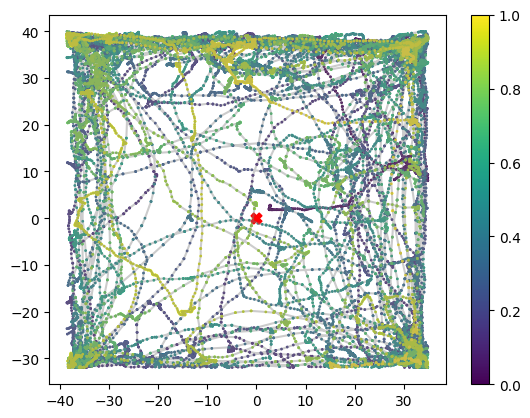

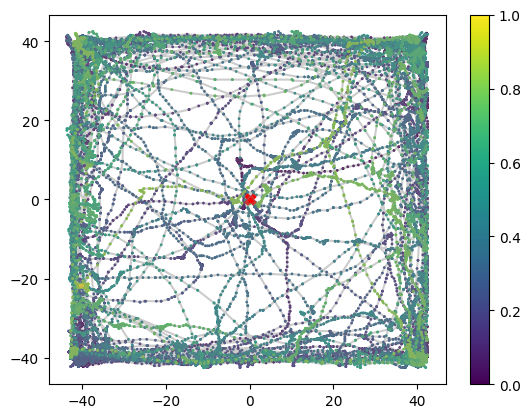

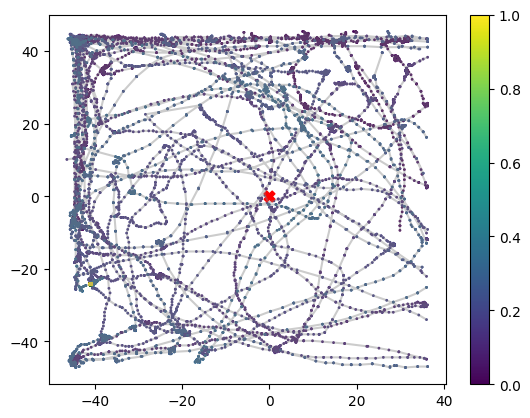

In [4]:
tr11 = datasets['Trace_1.1']  # TODO: params to config
tr12 = datasets['Trace_1.2']  
tr2 = datasets['Trace_2']
tr5 = datasets['Trace_5']

tr4 = cut_jumps(datasets['Trace_4'], xmax=40.4, xmin=-38.1, ymax=28.3, ymin=-47.6)
tr3 = cut_jumps(datasets['Trace_3'], xmax=46.8, xmin=-48, ymax=46, ymin=-47)
tr6 = cut_jumps(datasets['Trace_6'], xmax=45, xmin=-45, ymax=45, ymin=-42.2)
tr7 = cut_jumps(datasets['Trace_7'], xmax=35, xmin=-38.7, ymax=40, ymin=-32)
tr91 = cut_jumps(datasets['Trace_9.1'], xmax=42.5, xmin=-43.7, ymax=42.5, ymin=-42.7)
tr92 = cut_jumps(datasets['Trace_9.2'], xmax=36.3, xmin=-46.5, ymax=45.4, ymin=-47.3)

dfs = [tr11, tr12, tr2, tr3, tr4, tr5, tr6, tr7, tr91, tr92]
dfs_names = ['tr11', 'tr12', 'tr2','tr3','tr4','tr5','tr6','tr7', 'tr91','tr92']

In [ ]:
# ...

# Develop Funcs

In [ ]:
# 1. Find dt tresholds by hands for each traj, save

## 2. Create function:
def divide_traj_by_nans():
    pass
# a. Drop nans
# b. Find places where dt > dt_treshold
# c. Find idxs of start and end of this space period, save them to list 
# d. cut trajectory into subtrajectories by this periods
# e. return original trajectory, cutted subset and list of cuts

# So now we change a bit data structure:
# from {'tr4': df} to {'tr4': [df1, df2, ...]}

# Make resampling function, place it before all other functions, use after def divide_traj_by_nans()

# Find and put into one place all functinos that add new columns to dataframe (angle, dangle, area, etc.)

# Save all preprocessed datasets to work with them further!

# Think how all other functions will operate with new data format

### Find dt tresholds by hands for each traj, save

In [22]:
dfs = [tr11, tr12, tr2, tr3, tr4, tr5, tr6, tr7, tr91, tr92]
dfs_names = ['tr11', 'tr12', 'tr2','tr3','tr4','tr5','tr6','tr7', 'tr91','tr92']

dfs_dict = {}
for k, val in zip(dfs_names, dfs):
    dfs_dict[k] = val

In [23]:
# Find data that has Nans and how many 
for k, df in dfs_dict.items():
    print(k, df.shape)
    df_dropped = df.dropna()

    dropped_num = df.shape[0] - df_dropped.shape[0]
    print('Dropped samples num: ', dropped_num)
    print('--'*15)

tr11 (52568, 3)
Dropped samples num:  0
------------------------------
tr12 (52523, 3)
Dropped samples num:  0
------------------------------
tr2 (52298, 3)
Dropped samples num:  0
------------------------------
tr3 (6197, 3)
Dropped samples num:  730
------------------------------
tr4 (16755, 3)
Dropped samples num:  6994
------------------------------
tr5 (27369, 3)
Dropped samples num:  0
------------------------------
tr6 (49783, 3)
Dropped samples num:  2492
------------------------------
tr7 (48912, 3)
Dropped samples num:  2945
------------------------------
tr91 (51862, 3)
Dropped samples num:  588
------------------------------
tr92 (46366, 3)
Dropped samples num:  2278
------------------------------


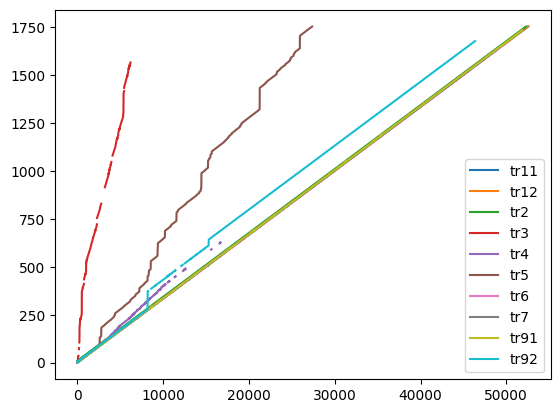

In [24]:
# Look at time steps
for k, df in dfs_dict.items(): 
    dat_times = np.asarray(df['time'].values.tolist())
    plt.plot(dat_times, label=k)
plt.legend()
plt.show()

# We can see, that some trajectories are short, with many Nans and time jumps
# [tr91,tr2,tr12,tr11, tr6, tr7] - normal; [tr92] - almost normal;
# [tr3, tr5, ] - are bad; [tr4] - totaly bad, drop it

In [25]:
del dfs_dict['tr4'] 
dfs_dict.keys()

dict_keys(['tr11', 'tr12', 'tr2', 'tr3', 'tr5', 'tr6', 'tr7', 'tr91', 'tr92'])

for:  tr11
Unique:  [0.033 0.034]
Counts:  [33292 19275]
---------------
for:  tr12
Unique:  [0.033 0.034 0.1   1.401]
Counts:  [33261 19258     2     1]
---------------
for:  tr2
Unique:  [0.033 0.034]
Counts:  [33121 19176]
---------------
for:  tr3
Unique:  [  0.133   0.134   0.266   0.267   0.4     0.401   0.533   0.534   0.667
   0.668   0.8     0.801   0.934   0.935   1.067   1.068   1.201   1.202
   1.334   1.335   1.468   1.601   1.602   1.735   1.736   1.868   1.869
   2.002   2.135   2.268   2.269   2.402   2.536   2.803   2.937   3.069
   3.203   3.47    4.138   4.404   4.538   4.671   4.672   5.338   6.406
   7.475  12.412  13.213  14.681  25.225  46.313  53.921 103.97  116.25
     nan]
Counts:  [2816 2472    1   18   13   15    1   10    9    2    4    6    5    2
    1    1    4    2    1    1    2    3    2    3    1    1    1    4
    1    1    1    1    3    4    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1  764]
---

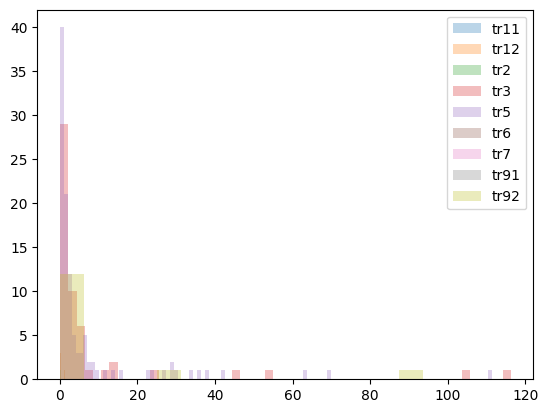

In [29]:
# Find hyperparameters for dt for each trajectory

for k, df in dfs_dict.items(): 
    dat_times = np.asarray(df['time'].values.tolist())
    dat_dt_times = np.diff(dat_times)

    uniq_dt, counts = np.unique(dat_dt_times.round(3), return_counts=True)

    plt.hist(uniq_dt, bins=uniq_dt.shape[0], label=k, alpha=0.3)
    print('for: ', k)
    print('Unique: ', uniq_dt)
    print('Counts: ', counts)
    print('-'*15)

plt.legend()
plt.show()

# tr11: 0.034, no outliers;
# tr12: 0.034, 3  outliers;
# tr2 : 0.034, no outliers;

# tr3 : 0.134, many nans and outliers, (high minimal sampling rate!);
# tr5 : 0.034, no nans and small outliers;
# tr6 : 0.034, no outliers, a lot of nans;
# tr7 : 0.034, no outliers, a lot of nans;
# tr91: 0.034, outliers, a lot of nans;
# tr92: 0.034, outliers, a lot of nans;

dt_threshold = 0.035  # dt values differnce that we count as normal (e.g. 0.133 and 0.134)

In [67]:
dtes = dfs_dict['tr12']
dtes.loc[22542-1], dtes.loc[22542], dtes.loc[22542+1]
np.abs(753.119 - 753.219) > 0.035

True

In [80]:
# Divide trajectory in sub-trajectories

dt_threshold = 0.035  # dt values differnce that we count as normal (e.g. 0.133 and 0.134)
dfs_dict_with_subtraj = {}

for k, df in dfs_dict.items(): 
    # dat_times = np.asarray(df['time'].values.tolist())
    # dat_dt_times = np.diff(dat_times)

    dt_times = df['time'].diff().to_numpy()
    dt_times[0] = 0.
    # print(dt_times)

    div_idx = np.where(dt_times > dt_threshold)[0]
    div_idx = np.asarray(div_idx)

    print('l', div_idx, len(div_idx))

    if len(div_idx) > 0:
        end_idx = div_idx - 1
        print('e', end_idx)

    # print(dt_times.iloc[dt_times > dt_threshold])

    # dfs_dict_with_subtraj[k] = []
    if k =='tr12':
        break

l [] 0
l [22542 45421 45525] 3
e [22541 45420 45524]


In [ ]:
####### STOPED HERE -===================================================
# ======================================================================

### Create function to adress recording gaps

In [ ]:
def divide_traj_by_nans(df): # TODO
    # 1. Drop nans
    old_len = df.shape[0]
    df = df.dropna()
    print(f"Dropped {old_len - df.shape[0]} Nans")

    # 2. 


In [ ]:
def resample_data(): # TODO
    pass

In [ ]:
def save_preprocessed_data():  # TODO
    pass